# Rasterio
Die Kernkompetenz von Rasterio ist das Arbeiten mit Rasterdaten. Rasterformate sind bspw. häufige Formate von Satellitenbildern oder Geländemodellen. Formate dafür sind unter anderem TIFF oder GeoTIFF. Rasterio bietet eine Schnittstelle basierend auf N-dimensionalen Numpy Arrays und GeoJSON mit solchen Rastern zu arbeiten.

Die komplette Dokumentation findet ihr [hier](https://rasterio.readthedocs.io/en/latest/#).

In [1]:
import rasterio
from rasterio.mask import mask
import matplotlib.pyplot as plt
import numpy as np
import os
import fiona

Als Beispiel betrachten wir einen zu übungszwecken nachgebesserter Datensatz der Stadt Zürich. Er stellt die $CO_2$ Gesamtemissionen im Jahr 2015 dar. 

## Raster darstellen
Als erstes möchten wir den Datensatz ohne jegliche Manipulationen anzeigen. Es gibt dabei zwei Möglichkeiten eine Rasterdatei zu öffen: Entweder mittels

    with rasterio.open(path_to_input_raster, 'r') as src:

wie wir es im Abschnitt zum Thema Maskierung machen oder auf direktem Weg wie im nachfolgenden Codeblock:


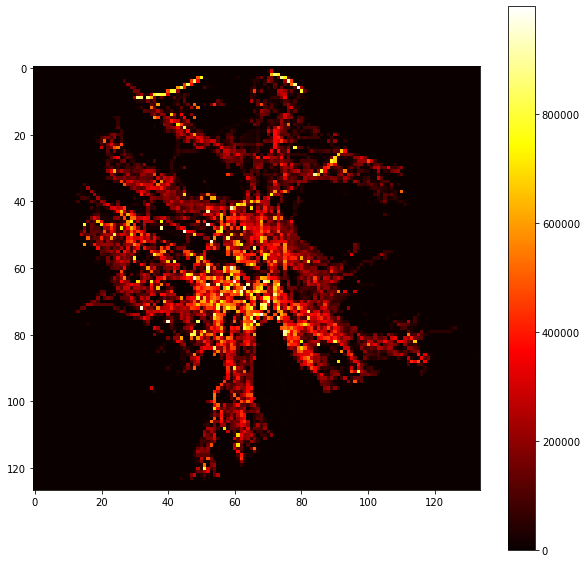

In [2]:
# Plot Raster
plt.figure(figsize=(10, 10))
src = rasterio.open(os.path.join('data', 'ha_co2_gesamt_edited_2015.tif'))

# Daten aus derm ersten Kanal auslesen (vgl. Vorlesung Erdbeobachtung)
raster = src.read(1)
plt.imshow(raster, cmap = 'hot')
plt.colorbar()
plt.show()


Wird ein Raster direkt geöffnet, soll es nach dem ausführen der Operationen wieder geschlossen werden. Dies wird mit `src.close()` gemacht. Im obigen Codeblock haben wir dies jedoch ausgelassen, da wir das geöffnete Raster zu Illustrationszwecken später noch verwenden möchten.

Die Visualisierung wurde mit Matplotlib gemacht. Man könnte bspw. je nach Anwendung eine andere Colormap wählen oder die Bildgrösse verändern. Für weitere Anpassungmöglichkeiten könnt ihr euch das Handout zur Matplotlib anschauen, da werden einige Optionen ausführlicher aufgezeigt.

## Maskierungen
Um das Ganze etwas interessanter zu machen, möchten wir jetzt eine Datenanalyse durchführen: Für jeden Kreis der Stadt soll berechnet werden, wie viel $CO_2$ ausgestossen wurde. Dazu verwenden wir sogenannte Maskierungen. Intuitiv gesprochen heisst das, wir nehmen die Geometrie eines Kreises und legen diese über das Raster (maskieren das Raster), alle Zellen die dann "unterhalb" dieser Maske liegen, sollen aufaddiert werden.

In [3]:
def calculate_total_emission (path_to_input_raster, shapes):
    # List mit Kreisen
    total_emission_kreise = []

    # Raster öffnen
    with rasterio.open(path_to_input_raster, 'r') as src:

        # Über alle Kreise iterieren
        for stadt_kreis in shapes:
            kreis = list()
            kreis.append(stadt_kreis)

            # Maskieren
            out_i, out_t = rasterio.mask.mask(src, kreis, nodata=0, crop=True)
            out_i = np.squeeze(out_i.astype(int))

            total_emission_kreise.append(np.sum(out_i))
    return total_emission_kreise

Die Methode `rasterio.mask.mask(src, kreis, nodata=0, crop=True)` gibt uns zwei Elemente zurück (vgl. Zeile 14), wobei beide Numpy-Arrays sind. Das erste Element enthält die Werte aller Pixel innerhalb der maskierenden Geometrie und einen Nodata-Wert für alle anderen. `out_t` enthält die Mapping-Information der Maskierung, falls man in ein anderes Koordinatensystem transformieren möchte. Um unsere Fragestellung zu beantworten brauchen wir `out_t` nicht.

In Python ist es üblich, dass man Returns, die man nicht braucht, mit `_` bezeichnet. So wird kein Variablennamen unnötig belegt.

Eine weitere Problematik auf die man sensibilisiert sein sollte, wird ebenfalls auf Zeile 14 mit `nodata=0` behandelt. In den meisten Fällen (wenn auch nicht immer) ist einer oder mehrere Nodata-Werte definiert:

In [4]:
print("Nodatavals(): {}".format(src.nodatavals))
print("Nodata: {}".format(src.nodata))

Nodatavals(): (1.79e+308,)
Nodata: 1.79e+308


Häufig ist der Nodata-Wert 0. Es muss aber unbedingt überprüft werden, ob dies der Fall ist. Denn wird für die Maskierung kein Nodata-Wert spezifiziert, wird jener vom ursprünglichen Raster übernommen. Gerade für Berechnungen wie wir sie anstellen möchten, wäre dies problematisch und würde zu gravierenden Fehlern führen. Auch da ist eine Plausibilitätsprüfung der Ergebnisse sehr zu empfehlen.

In [5]:
with fiona.open(os.path.join('data', 'stadtkreise_proj.json'), 'r') as shapefile:
    shapes = [feature['geometry'] for feature in shapefile]
    namen = [feature['properties']['Bezeichnnung'] for feature in shapefile]
    emissionen_pro_kreis = calculate_total_emission (os.path.join('data', 'ha_co2_gesamt_edited_2015.tif'), shapes)

resultat = dict(zip(namen, emissionen_pro_kreis))
print(sorted(resultat.items(), key=lambda x:x[1], reverse=True))

[('Kreis 9', 118355358), ('Kreis 11', 113646497), ('Kreis 2', 112267522), ('Kreis 7', 105116326), ('Kreis 3', 102939779), ('Kreis 10', 83649298), ('Kreis 6', 72591435), ('Kreis 4', 66949589), ('Kreis 8', 56379396), ('Kreis 1', 55754838), ('Kreis 5', 41308185), ('Kreis 12', 31926700)]


Somit haben wir die eingangs gestellte Frage, wie viel $CO_2$ pro Kreis im Jahr 2015 wurde ausgestossen, beantwortet.
## Raster schreiben
Das Schreiben von Rasterdaten mittels Rasterio erinnert stark an die bereits bekannte Vorgehensweise für Vektordaten (Fiona). Zu Illustrationszwecken möchten wir allen Pixeln im Kreis 9 den Wert 0 zuweisen und dann das neue Raster unter neuem Namen abspeichern:

In [6]:
with fiona.open(os.path.join('data', 'stadtkreise_proj.json'), 'r') as shapefile:
    kreis9_shape = shapefile[0]['geometry']

# Kreis 9 zu 0 setzen mittels Maske
out_i, _ = rasterio.mask.mask(src, [kreis9_shape], invert=True, nodata=0)
with rasterio.Env():
    # Profil der Ausgansdatei
    profile = src.profile

    # Profil für neue Datei anpassen
    profile.update(
        dtype=rasterio.int32,
        nodata=0.0
    )

    # Neue Datei schreiben
    with rasterio.open('ha_CO2_ohne-Kreis-9.tif', 'w', **profile) as dst:
        dst.write(np.squeeze(out_i).astype(rasterio.int32), 1)


Wir haben also den Datentyp der Pixelwerte auf Integer und den Nodata-Wert auf 0.0 gesetzte. Zudem haben wir den kompletten Kreis auf 0 gesetzt. Der nachfolgende Codeblock dient der Überprüfung:

Im alten Raster: Nodata-Wert: 1.79e+308; Pixelwert an der Stelle [70,50]: 607295.08805
Im neuen Raster: Nodata-Wert: 0.0; Pixelwert an der Stelle [70,50]: 607295


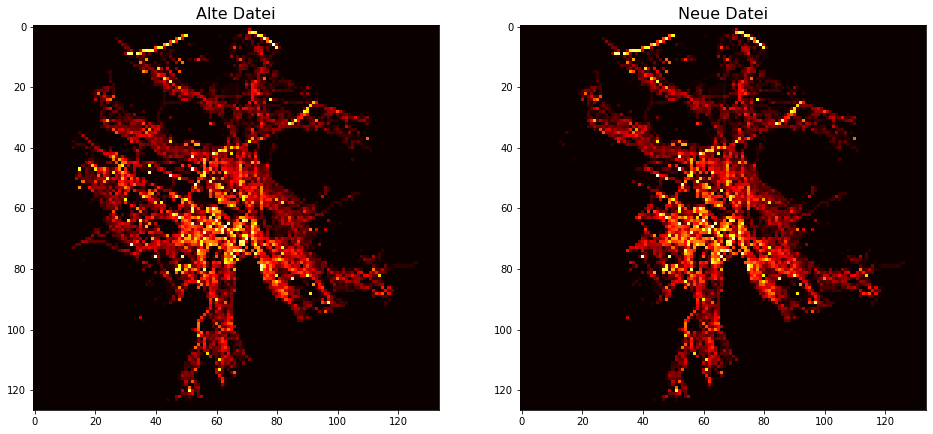

In [7]:
src_alt = rasterio.open(os.path.join('data', 'ha_co2_gesamt_edited_2015.tif'))
src_neu = rasterio.open('ha_CO2_ohne-Kreis-9.tif')


print("Im alten Raster: Nodata-Wert: {}; Pixelwert an der Stelle [70,50]: {}".format(src.nodata, src.read(1)[70,50]))
print("Im neuen Raster: Nodata-Wert: {}; Pixelwert an der Stelle [70,50]: {}".format(src_neu.nodata, src_neu.read(1)[70,50]))

# Plots
fig, ax = plt.subplots(1,2, figsize=(16,9))
ax[0].imshow(src.read(1), cmap = 'hot')
ax[0].set_title('Alte Datei', fontsize=16)
ax[1].imshow(src_neu.read(1), cmap = 'hot')
ax[1].set_title('Neue Datei', fontsize=16)
plt.show()

In [8]:
# Raster schliessen
src.close()
src_neu.close()